In [1]:
import awkward as ak
import numpy as np
import uproot as uproot
import matplotlib.pyplot as plt
import mplhep as hep
import vector as vec
import pandas as pd

import matplotlib as mpl

plt.style.use(hep.style.CMS)
%matplotlib inline

In [2]:
filenameS = '/eos/user/a/aperego/tagger/tree_Zjj_10k.root'
fileSignal = uproot.open(filenameS)

filenameB = '/eos/user/a/aperego/tagger/tree_DY_10k.root'
fileBkg = uproot.open(filenameB)

In [3]:
def load_branch_with_highest_cycle(file, branch_name):
    # Get all keys in the file
    all_keys = file.keys()
    # Filter keys that match the specified branch name
    matching_keys = [key for key in all_keys if key.startswith(branch_name)]
    if not matching_keys:
        raise ValueError(f"No branch with name '{branch_name}' found in the file.")
    # Find the key with the highest cycle
    highest_cycle_key = max(matching_keys, key=lambda key: int(key.split(";")[1]))
    # Load the branch with the highest cycle
    branch = file[highest_cycle_key]
    return branch

In [4]:
fS_LHEParticles = load_branch_with_highest_cycle(fileSignal, "LHEParticles")
fS_GenJets = load_branch_with_highest_cycle(fileSignal, "GenJets")
fS_GenParticles = load_branch_with_highest_cycle(fileSignal, "GenParticles")

fB_LHEParticles = load_branch_with_highest_cycle(fileBkg, "LHEParticles")
fB_GenJets = load_branch_with_highest_cycle(fileBkg, "GenJets")
fB_GenParticles = load_branch_with_highest_cycle(fileBkg, "GenParticles")

In [5]:
print(fS_LHEParticles.keys())
print(fS_GenJets.keys())
print(fS_GenParticles.keys())

['LHEPart_pt', 'LHEPart_eta', 'LHEPart_phi', 'LHEPart_mass', 'LHEPart_pdgId', 'LHEPart_status']
['GenJet_pt', 'GenJet_eta', 'GenJet_phi', 'GenJet_mass', 'GenJet_nConstituents', 'GenJet_constituents']
['nGenPart', 'GenPart_pt', 'GenPart_eta', 'GenPart_phi', 'GenPart_mass', 'GenPart_pdgId']


In [6]:
LHEParticles_s = fS_LHEParticles.arrays(fS_LHEParticles.keys())
GenJets_s = fS_GenJets.arrays(fS_GenJets.keys())
GenParticles_s = fS_GenParticles.arrays(fS_GenParticles.keys())

LHEParticles_b = fB_LHEParticles.arrays(fB_LHEParticles.keys())
GenJets_b = fB_GenJets.arrays(fB_GenJets.keys())
GenParticles_b = fB_GenParticles.arrays(fB_GenParticles.keys())

In [7]:
def getJetConstituents(i, nConst, allConst):
    return allConst[sum(nConst[:i]):sum(nConst[:i+1])]

In [8]:
def getManyJetsConstituents(i, j, nConst, allConst):
    return allConst[sum(nConst[:i]):sum(nConst[:j+1])]

In [9]:
getManyJetsConstituents(0,3, GenJets_b.GenJet_nConstituents[0], GenJets_b.GenJet_constituents[0])

<Array [692, 378, 689, 376, ... 261, 33, 140] type='125 * int32'>

## input to GNN

In [10]:
def wrapInPhi(phi):
    """Map angle values to the range [-pi, pi]."""
    return (phi + np.pi) % (2 * np.pi) - np.pi

In [35]:
def getJetsDataFrame(GenJets, isSignal, verbose=False):
    genJets_pt = GenJets.GenJet_pt
    genJets_eta = GenJets.GenJet_eta
    genJets_phi = wrapInPhi(GenJets.GenJet_phi)
    genJets_mass = GenJets.GenJet_mass
    nConstituents = GenJets.GenJet_nConstituents
    events_id = np.concatenate([np.ones(len(genJets_pt[idx]))*idx for idx in range(len(genJets_pt))])
    if not isSignal:
        events_id += 10000
        
    # Flatten the arrays (along axis=0, combining the particles from all events)
    flat_pt = ak.flatten(genJets_pt)
    flat_eta = ak.flatten(genJets_eta)
    flat_phi = ak.flatten(genJets_phi)
    flat_mass = ak.flatten(genJets_mass)
    jetpull = ak.zeros_like(flat_mass)
    flat_nConstituents = ak.flatten(nConstituents)
    labels = ak.ones_like(flat_pt) if isSignal else ak.zeros_like(flat_pt)

    # Create a pandas DataFrame
    df = pd.DataFrame({
        'ev': events_id,
        'pt': flat_pt,
        'eta': flat_eta,
        'phi': flat_phi,
        'mass': flat_mass,
        'ncostituents': flat_nConstituents,
        'jetpull': jetpull,
        'label': labels
    })
    df['ev'] = df['ev'].astype(int)
# row: leptoni @ LHE
# filtro eventi con getti con pt>30?
# Group by 'ev' and filter groups that have at least two rows with pt > 30
#filtered_df = df.groupby('ev').filter(lambda x: (x['pt'] > 30).sum() >= 2)
# nel get si fa df[df["evt"==idx]]


    if verbose:
        print(df)
    
    return df

In [36]:
dfS = getJetsDataFrame(GenJets_s, True)
dfB = getJetsDataFrame(GenJets_b, False)

In [37]:
### LEPTONS, bkg
def getLeptonsDataFrame(LHEParticles, isSignal, verbose=False):
    lhePart_pgdid = (10 < abs(LHEParticles.LHEPart_pdgId)) & (abs(LHEParticles.LHEPart_pdgId) < 20)

    lhePart_pt = LHEParticles.LHEPart_pt[lhePart_pgdid]
    lhePart_eta = LHEParticles.LHEPart_eta[lhePart_pgdid]
    lhePart_phi = wrapInPhi(LHEParticles.LHEPart_phi[lhePart_pgdid])
    lhePart_mass = LHEParticles.LHEPart_mass[lhePart_pgdid]

    events_id = np.concatenate([np.ones(len(lhePart_pt[idx]))*idx for idx in range(len(lhePart_pt))])
    if not isSignal:
        events_id += 10000

    # Flatten the arrays (along axis=0, combining the particles from all events)
    flat_pt = ak.flatten(lhePart_pt)
    flat_eta = ak.flatten(lhePart_eta)
    flat_phi = ak.flatten(lhePart_phi)
    flat_mass = ak.flatten(lhePart_mass) 
    ncostituents = ak.zeros_like(flat_mass)
    jetpull = ak.zeros_like(flat_mass)
    label = ak.ones_like(flat_pt) if isSignal else ak.zeros_like(flat_pt)

    # Create a pandas DataFrame
    df = pd.DataFrame({
        'ev': events_id,
        'pt': flat_pt,
        'eta': flat_eta,
        'phi': flat_phi,
        'mass': flat_mass,
        'ncostituents': ncostituents,
        'jetpull': jetpull,
        'label': label
    })

    df['ev'] = df['ev'].astype(int)
    df['ncostituents'] = df['ncostituents'].astype(int)
    df['label'] = df['label'].astype(int)

    if verbose:
        print(df)
    return df

In [38]:
dfLS = getLeptonsDataFrame(LHEParticles_s, True)
dfLB = getLeptonsDataFrame(LHEParticles_b, False)
df = pd.concat([dfLS, dfLB, dfS, dfB], axis=0, ignore_index=True)
df = df.sort_values(by=['ev', 'ncostituents'])
df #.groupby("ev") #[(df["ev"] == 1) & (df["label"] == 1)]

,ev,pt,eta,phi,mass,ncostituents,jetpull,label
0,0,12.456040,-1.881445,-0.626607,1.777000,0,0.0,1.0
1,0,41.092743,0.203865,-0.346025,1.777000,0,0.0,1.0
40018,0,2.434860,3.068902,-1.729700,0.497610,1,0.0,1.0
40035,0,1.667527,2.296228,0.160516,0.139570,1,0.0,1.0
40041,0,1.485974,-3.037168,-1.526291,0.139570,1,0.0,1.0
...,...,...,...,...,...,...,...,...
1063175,19999,6.225800,1.640749,-1.481726,2.871529,9,0.0,0.0
1063174,19999,6.786078,-0.239027,-0.509404,1.659204,10,0.0,0.0
1063171,19999,46.884094,2.172994,0.487516,2.878165,11,0.0,0.0
1063169,19999,51.814034,0.656977,3.131070,8.245144,20,0.0,0.0


## train test split

In [15]:
NEVENTS = 20000
train_events = np.random.choice(np.arange(NEVENTS), size=int(NEVENTS*0.9), replace=False)

df_train = df[df['ev'].isin(train_events)]
df_test = df[~df['ev'].isin(train_events)]

## GNN

In [18]:
# install Pytorch Geometric
import torch
print(torch.__version__)

import torch_geometric
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import FixedPoints
from sklearn.model_selection import train_test_split
from torch_cluster import knn_graph

2.1.0a0


In [19]:
class MyGraphDataset(torch_geometric.data.Dataset):
    def __init__(self, data, k=5, transform=None, pre_transform=None):
        super(MyGraphDataset, self).__init__(transform, pre_transform)
        self.data_l = data[['ev','label']]
        self.data_f = data.drop(columns=['label'])
        self.num_samples = data['ev'].nunique()
        self.k = k # number of nearest neighbors
        self.uniqueIndices = data['ev'].unique()

    def len(self):
        return self.num_samples

    def get(self, idx):   
        evIdx = self.uniqueIndices[idx]
        graph_data = self.data_f[self.data_f["ev"]==evIdx]
        graph_label = self.data_l[self.data_l["ev"]==evIdx]['label'].nunique()

        #pos_tmp = graph_data[sel]
        pos = torch.tensor(graph_data[['eta', 'phi']].values, dtype=torch.float32) #eta_rel and phi_rel
        x = torch.tensor(graph_data[['pt', 'mass', 'ncostituents']].values, dtype=torch.float32)
        y = torch.tensor(np.asarray(graph_label), dtype=torch.long)
        
        # compute edge_index (using pos)
        # fix: phi is wrap: change distance definition -> coseno invece di euclidea (sin^2 diff degli angoli /2)
        edge_index = knn_graph(pos, k=self.k, loop=False)

        # pyg data object
        data = Data(x=x, y=y, pos=pos, edge_index=edge_index, category=y)

        return data

In [32]:
# number of nearest neighbors
k = 5

# Create Datasets
trainset = MyGraphDataset(df_train, k=k)
# validset = MyGraphDataset(X_valid, y_valid, k=k)
testset = MyGraphDataset(df_test, k=k)

# Create DataLoaders
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, drop_last=True,num_workers=8)
validloader = DataLoader(testset, batch_size=256, shuffle=False, drop_last=False)
testloader = DataLoader(testset, batch_size=4, shuffle=False, drop_last=False,num_workers=8)

In [21]:
trainset[5].x.unsqueeze(1)

tensor([[[ 2.1049e+01,  4.1861e-05,  0.0000e+00]],

        [[ 7.8331e+01, -3.0682e-04,  0.0000e+00]],

        [[ 7.8264e+01,  5.2598e+00,  1.0000e+00]],

        [[ 3.7126e+01,  5.1255e+00,  1.0000e+00]],

        [[ 3.5366e+01,  5.0268e+00,  1.0000e+00]],

        [[ 2.1360e+01,  1.0566e-01,  1.0000e+00]],

        [[ 3.0092e+00,  6.0558e-01,  1.0000e+00]],

        [[ 2.7451e+00,  2.0079e+00,  1.0000e+00]],

        [[ 2.4034e+00,  3.0117e-01,  1.0000e+00]],

        [[ 2.3337e+00,  9.7299e-01,  1.0000e+00]],

        [[ 2.2577e+00,  2.7394e+00,  1.0000e+00]],

        [[ 2.2556e+00,  4.3751e-01,  1.0000e+00]],

        [[ 1.7724e+00,  4.9368e-01,  1.0000e+00]],

        [[ 1.6571e+00,  1.0547e+00,  1.0000e+00]],

        [[ 1.5739e+00,  2.6987e-01,  1.0000e+00]],

        [[ 1.5703e+00,  5.4556e-01,  1.0000e+00]],

        [[ 1.4915e+00,  6.8909e-01,  1.0000e+00]],

        [[ 1.4682e+00,  8.1528e-01,  1.0000e+00]],

        [[ 1.4439e+00,  1.2730e+00,  1.0000e+00]],

        [[ 1

In [22]:
trainset[5].x

tensor([[ 2.1049e+01,  4.1861e-05,  0.0000e+00],
        [ 7.8331e+01, -3.0682e-04,  0.0000e+00],
        [ 7.8264e+01,  5.2598e+00,  1.0000e+00],
        [ 3.7126e+01,  5.1255e+00,  1.0000e+00],
        [ 3.5366e+01,  5.0268e+00,  1.0000e+00],
        [ 2.1360e+01,  1.0566e-01,  1.0000e+00],
        [ 3.0092e+00,  6.0558e-01,  1.0000e+00],
        [ 2.7451e+00,  2.0079e+00,  1.0000e+00],
        [ 2.4034e+00,  3.0117e-01,  1.0000e+00],
        [ 2.3337e+00,  9.7299e-01,  1.0000e+00],
        [ 2.2577e+00,  2.7394e+00,  1.0000e+00],
        [ 2.2556e+00,  4.3751e-01,  1.0000e+00],
        [ 1.7724e+00,  4.9368e-01,  1.0000e+00],
        [ 1.6571e+00,  1.0547e+00,  1.0000e+00],
        [ 1.5739e+00,  2.6987e-01,  1.0000e+00],
        [ 1.5703e+00,  5.4556e-01,  1.0000e+00],
        [ 1.4915e+00,  6.8909e-01,  1.0000e+00],
        [ 1.4682e+00,  8.1528e-01,  1.0000e+00],
        [ 1.4439e+00,  1.2730e+00,  1.0000e+00],
        [ 1.3447e+00,  1.2813e+00,  1.0000e+00],
        [ 1.3220e+00

In [23]:
# d = next(iter(trainloader))
# d.batch

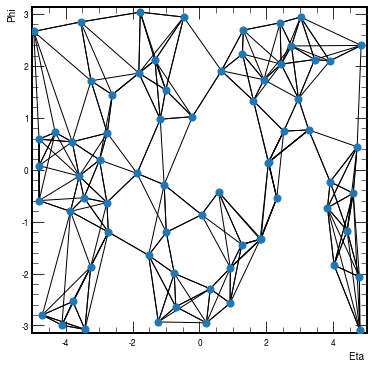

In [24]:
def visualize_points(pos, x, edge_index=None):
    fig = plt.figure(figsize=(6, 6))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')

    
    plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
   
    plt.xlim((-5,5))
    plt.ylim((-np.pi, np.pi))
    plt.xlabel('Eta ')
    plt.ylabel('Phi')
    plt.show()

data = trainset[2]

visualize_points(data.pos, data.x, data.edge_index)

In [25]:
from matplotlib import colors as mcolors
colors = list(mcolors.TABLEAU_COLORS.keys())
def get_color(index):
    wrapped_index = index % len(colors)
    return colors[wrapped_index]

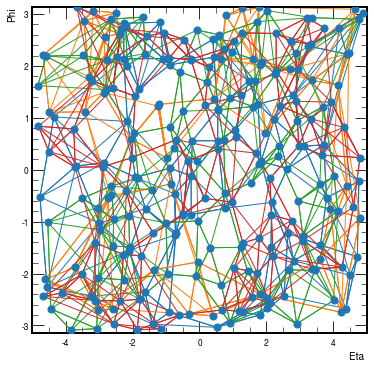

In [26]:
def visualize_batch(pos, x, edge_index=None, batch=None):
    fig = plt.figure(figsize=(6, 6))
        
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             if batch is not None:
                 c=get_color(batch[src])
             else:
                 c="black"
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color=c)
            
   
    plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
   

    plt.axis('on')
    plt.xlim((-5,5))
    plt.ylim((-np.pi, np.pi))
    plt.xlabel('Eta ')
    plt.ylabel('Phi')
    plt.show()
data = next(iter(testloader))
visualize_batch(data.pos,data.x, data.edge_index,data.batch)

In [27]:
# GNN model in pytorch geometric: we'll use a simple convolutional GNN based on the GCNConv message passing graph convolution
# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html


import torch.nn as nn
from torch_geometric.nn import GCNConv, global_max_pool,PointNetConv,global_mean_pool
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.utils import dropout_node,dropout_edge
import torch.nn.functional as F

class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.pre_feat = nn.Linear(input_dim, hidden_dim)
        self.pre_feat2 = nn.Linear(hidden_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.bn1 =BatchNorm(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 =BatchNorm(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.bn3 =BatchNorm(hidden_dim)
        #self.conv4 = GCNConv(hidden_dim, hidden_dim)
        #self.bn4 =BatchNorm(hidden_dim)
        #self.conv5 = GCNConv(hidden_dim, hidden_dim)
        #self.bn5 =BatchNorm(hidden_dim)
        #self.conv6 = GCNConv(hidden_dim, hidden_dim)
        #self.bn6 =BatchNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        # when loading data use .unsqueeze(1) if the data has only one column
        pos, feat, edge_index, batch = data.pos, data.x, data.edge_index, data.batch
        feat = torch.cat((feat, pos), dim=1)

        feat = F.relu(self.pre_feat(feat))
        feat = F.relu(self.pre_feat2(feat))
        feat = F.dropout(feat, p=0.5, training=self.training)

        x = F.relu(self.conv1(feat, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
#         x = F.relu(self.conv3(x, edge_index))
#         x = self.bn3(x)
        x = x + feat
        x = global_mean_pool(x, batch)  # Aggregate node features
        x = F.dropout(x, p=0.5, training=self.training)
        x =  F.relu(self.fc(x))
        x = self.fc2(x)
        return x

In [28]:
# test the model on one batch
from torch_geometric.nn import summary
model = GNN(input_dim=5, hidden_dim=128, output_dim=5)
data = next(iter(trainloader))
output = model(data)

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/si

In [29]:
print(output.shape)
print(summary(model, data))

torch.Size([256, 5])
+----------------------------+--------------------------+----------------+----------+
| Layer                      | Input Shape              | Output Shape   | #Param   |
|----------------------------+--------------------------+----------------+----------|
| GNN                        | [14215, 14215]           | [256, 5]       | 84,741   |
| ├─(pre_feat)Linear         | [14215, 5]               | [14215, 128]   | 768      |
| ├─(pre_feat2)Linear        | [14215, 128]             | [14215, 128]   | 16,512   |
| ├─(conv1)GCNConv           | [14215, 128], [2, 71075] | [14215, 128]   | 16,512   |
| ├─(bn1)BatchNorm           | [14215, 128]             | [14215, 128]   | 256      |
| │    └─(module)BatchNorm1d | [14215, 128]             | [14215, 128]   | 256      |
| ├─(conv2)GCNConv           | [14215, 128], [2, 71075] | [14215, 128]   | 16,512   |
| ├─(bn2)BatchNorm           | [14215, 128]             | [14215, 128]   | 256      |
| │    └─(module)BatchNorm1d | [1

In [30]:
import torch_scatter
print(torch_scatter.__version__)

2.1.1


In [33]:
# training loop
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# move model to GPU
model = GNN(input_dim=5, hidden_dim=128, output_dim=5).to(device)


# initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# training loop
num_epochs = 150
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

best_valid_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # set model to training mode
    model.train()
    for i, batch in enumerate(trainloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        outputs = model(batch)
        loss = criterion(outputs, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch.y.size(0)
        train_correct += (predicted == batch.y).sum().item()

    # Validation
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    # set model to evaluation mode
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(validloader):
            batch = batch.to(device)
            outputs = model(batch)
            loss = criterion(outputs, batch.y)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            valid_total += batch.y.size(0)
            valid_correct += (predicted == batch.y).sum().item()

    # Calculate epoch metrics
    train_accuracy = 100 * train_correct / train_total
    valid_accuracy = 100 * valid_correct / valid_total
    epoch_time = time.time() - start_time

    # Print and store metrics
    print('Epoch %d: train loss: %.3f, train acc: %.3f%%, valid loss: %.3f, valid acc: %.3f%%, time: %.3fs' %
          (epoch + 1, train_loss / len(trainloader), train_accuracy,
           valid_loss / len(validloader), valid_accuracy, epoch_time))

    train_losses.append(train_loss / len(trainloader))
    valid_losses.append(valid_loss / len(validloader))
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    scheduler.step(valid_accuracy)
    print("lr: ", optimizer.param_groups[0]['lr'])

    # Save model if validation loss improves
    if valid_loss/len(validloader) < best_valid_loss:
        best_valid_loss = valid_loss/len(validloader)
        torch.save(model.state_dict(), 'best_model_gnn.pth')
        print("Model saved!")

cuda


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/si

Epoch 1: train loss: 0.028, train acc: 98.588%, valid loss: 0.000, valid acc: 100.000%, time: 30.532s
lr:  0.03
Model saved!


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/si

Epoch 2: train loss: 0.000, train acc: 100.000%, valid loss: 0.000, valid acc: 100.000%, time: 30.479s
lr:  0.03


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/si

Epoch 3: train loss: 0.000, train acc: 100.000%, valid loss: 0.000, valid acc: 100.000%, time: 30.750s
lr:  0.03


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/si

Epoch 4: train loss: 0.000, train acc: 100.000%, valid loss: 0.000, valid acc: 100.000%, time: 30.808s
lr:  0.03


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/si

Epoch 5: train loss: 0.000, train acc: 100.000%, valid loss: 0.000, valid acc: 100.000%, time: 30.541s
lr:  0.03


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/si

Epoch 6: train loss: 0.000, train acc: 100.000%, valid loss: 0.000, valid acc: 100.000%, time: 31.257s
lr:  0.03


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/si

KeyboardInterrupt: 

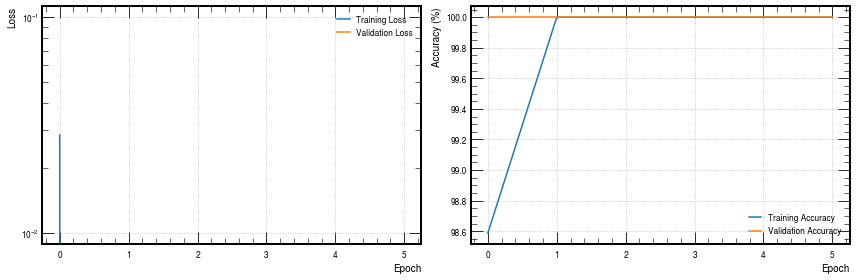

In [34]:
# plot loss and accuracy vs epoch for training and validation

# Plot loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid("on")
plt.yscale("log")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid("on")

plt.tight_layout()
plt.show()